In [1]:
import os
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import numpy as np
import random
from collections import namedtuple, deque

In [2]:
class ReplayBuffer():
    def __init__(self, buffer_limit, DEVICE):
        self.buffer = deque(maxlen=buffer_limit)
        self.dev = DEVICE

    def put(self, transition):
        self.buffer.append(transition)

    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done = transition
            s_lst.append(s)
            a_lst.append(a)
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask = 0.0 if done else 1.0
            done_mask_lst.append([done_mask])
        
        # # convert lists of numpy arrays to numpy arrays
        s_lst = np.array(s_lst, dtype=np.float32)
        a_lst = np.array(a_lst, dtype=np.float32)
        r_lst = np.array(r_lst, dtype=np.float32)
        s_prime_lst = np.array(s_prime_lst, dtype=np.float32)
        done_mask_lst = np.array(done_mask_lst, dtype=np.float32)

        s_batch = torch.tensor(s_lst, dtype=torch.float).to(self.dev)
        a_batch = torch.tensor(a_lst, dtype=torch.float).to(self.dev)
        r_batch = torch.tensor(r_lst, dtype=torch.float).to(self.dev)
        s_prime_batch = torch.tensor(s_prime_lst, dtype=torch.float).to(self.dev)
        done_batch = torch.tensor(done_mask_lst, dtype=torch.float).to(self.dev)

        # r_batch = (r_batch - r_batch.mean()) / (r_batch.std() + 1e-7)

        return s_batch, a_batch, r_batch, s_prime_batch, done_batch

    def size(self):
        return len(self.buffer)


class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, actor_lr):
        super(PolicyNetwork, self).__init__()

        self.fc_1 = nn.Linear(state_dim, 64)
        self.fc_2 = nn.Linear(64, 64)
        self.fc_mu = nn.Linear(64, action_dim)
        self.fc_std = nn.Linear(64, action_dim)

        self.lr = actor_lr

        self.LOG_STD_MIN = -20
        self.LOG_STD_MAX = 2
        self.max_action = 2
        self.min_action = -2
        self.action_scale = (self.max_action - self.min_action) / 2.0
        self.action_bias = (self.max_action + self.min_action) / 2.0

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x):
        x = F.leaky_relu(self.fc_1(x))
        x = F.leaky_relu(self.fc_2(x))
        mu = self.fc_mu(x)
        log_std = self.fc_std(x)
        log_std = torch.clamp(log_std, self.LOG_STD_MIN, self.LOG_STD_MAX)
        return mu, log_std

    def sample(self, state):
        mean, log_std = self.forward(state)
        std = torch.exp(log_std)
        reparameter = Normal(mean, std)
        x_t = reparameter.rsample()
        y_t = torch.tanh(x_t)
        action = self.action_scale * y_t + self.action_bias

        # # Enforcing Action Bound
        log_prob = reparameter.log_prob(x_t)
        log_prob = log_prob - torch.sum(torch.log(self.action_scale * (1 - y_t.pow(2)) + 1e-6), dim=-1, keepdim=True)

        return action, log_prob


class QNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, critic_lr):
        super(QNetwork, self).__init__()

        self.fc_s = nn.Linear(state_dim, 32)
        self.fc_a = nn.Linear(action_dim, 32)
        self.fc_1 = nn.Linear(64, 64)
        self.fc_out = nn.Linear(64, action_dim)

        self.lr = critic_lr

        self.optimizer = optim.Adam(self.parameters(), lr=self.lr)

    def forward(self, x, a):
        h1 = F.leaky_relu(self.fc_s(x))
        h2 = F.leaky_relu(self.fc_a(a))
        cat = torch.cat([h1, h2], dim=-1)
        q = F.leaky_relu(self.fc_1(cat))
        q = self.fc_out(q)
        return q


class SAC_Agent:
    def __init__(self):
        self.state_dim      = 3  # [cos(theta), sin(theta), theta_dot]
        self.action_dim     = 1  # [torque] in[-2,2]
        self.lr_pi          = 0.001
        self.lr_q           = 0.001
        self.gamma          = 0.98
        self.batch_size     = 200
        self.buffer_limit   = 100000
        self.tau            = 0.005   # for soft-update of Q using Q-target
        self.init_alpha     = 0.01
        self.target_entropy = -self.action_dim  # == -1
        self.lr_alpha       = 0.005
        self.DEVICE         = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory         = ReplayBuffer(self.buffer_limit, self.DEVICE)

        self.log_alpha = torch.tensor(np.log(self.init_alpha)).to(self.DEVICE)
        self.log_alpha.requires_grad = True
        self.log_alpha_optimizer = optim.Adam([self.log_alpha], lr=self.lr_alpha)

        self.PI  = PolicyNetwork(self.state_dim, self.action_dim, self.lr_pi).to(self.DEVICE)
        self.Q1        = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)
        self.Q1_target = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)
        self.Q2        = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)
        self.Q2_target = QNetwork(self.state_dim, self.action_dim, self.lr_q).to(self.DEVICE)

        self.Q1_target.load_state_dict(self.Q1.state_dict())
        self.Q2_target.load_state_dict(self.Q2.state_dict())

    def choose_action(self, s):
        with torch.no_grad():
            action, log_prob = self.PI.sample(s.to(self.DEVICE))
        return action, log_prob

    def calc_target(self, mini_batch):
        s, a, r, s_prime, done = mini_batch
        with torch.no_grad():
            a_prime, log_prob_prime = self.PI.sample(s_prime)
            entropy = - self.log_alpha.exp() * log_prob_prime
            q1_target, q2_target = self.Q1_target(s_prime, a_prime), self.Q2_target(s_prime, a_prime)
            q_target = torch.min(q1_target, q2_target)
            target = r + self.gamma * done * (q_target + entropy)
        return target

    def train_agent(self):
        mini_batch = self.memory.sample(self.batch_size)
        s_batch, a_batch, r_batch, s_prime_batch, done_batch = mini_batch

        td_target = self.calc_target(mini_batch)

        #### Q1 train ####
        q1_loss = F.smooth_l1_loss(self.Q1(s_batch, a_batch), td_target)
        self.Q1.optimizer.zero_grad()
        q1_loss.mean().backward()
        # nn.utils.clip_grad_norm_(self.q1.parameters(), 1.0)
        self.Q1.optimizer.step()
        #### Q1 train ####

        #### Q2 train ####
        q2_loss = F.smooth_l1_loss(self.Q2(s_batch, a_batch), td_target)
        self.Q2.optimizer.zero_grad()
        q2_loss.mean().backward()
        # nn.utils.clip_grad_norm_(self.q2.parameters(), 1.0)
        self.Q2.optimizer.step()
        #### Q2 train ####

        #### pi train ####
        a, log_prob = self.PI.sample(s_batch)
        entropy = -self.log_alpha.exp() * log_prob

        q1, q2 = self.Q1(s_batch, a), self.Q2(s_batch, a)
        q = torch.min(q1, q2)

        pi_loss = -(q + entropy)  # for gradient ascent
        self.PI.optimizer.zero_grad()
        pi_loss.mean().backward()
        # nn.utils.clip_grad_norm_(self.pi.parameters(), 2.0)
        self.PI.optimizer.step()
        #### pi train ####

        #### alpha train ####
        self.log_alpha_optimizer.zero_grad()
        alpha_loss = -(self.log_alpha.exp() * (log_prob + self.target_entropy).detach()).mean()
        alpha_loss.backward()
        self.log_alpha_optimizer.step()
        #### alpha train ####

        #### Q1, Q2 soft-update ####
        for param_target, param in zip(self.Q1_target.parameters(), self.Q1.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
        for param_target, param in zip(self.Q2_target.parameters(), self.Q2.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - self.tau) + param.data * self.tau)
        #### Q1, Q2 soft-update ####





In [3]:
def simulate_pendulum(state, action, mass, length,damping):
    dt = 0.05  # You might need to adjust the time step
    gravity = 9.81  # Acceleration due to gravity


    cos_theta, sin_theta, theta_dot = state
    torque = action[0]  # Assuming action is a single value

    # Calculate theta from cos(theta) and sin(theta)
    theta = np.arctan2(sin_theta, cos_theta)

    # Calculate moment of inertia
    inertia = mass * length**2

    # Calculate angular acceleration
    alpha = (torque - gravity * np.sin(theta) * length - damping * theta_dot) / inertia

    # Update theta and theta_dot
    next_theta = theta + theta_dot * dt
    next_theta_dot = theta_dot + alpha * dt

    # Convert theta back to cos(theta) and sin(theta)
    next_cos_theta = np.cos(next_theta)
    next_sin_theta = np.sin(next_theta)

    return np.array([next_cos_theta, next_sin_theta, next_theta_dot])

In [4]:
# Training parameters

agent = SAC_Agent()

EPISODES = 300
print_once = True
score_list = []

Training started!
EP:0, Avg_Score:-25694.9
EP:1, Avg_Score:-695.4
EP:2, Avg_Score:-817.6
EP:3, Avg_Score:-534.7
EP:4, Avg_Score:-522.3
EP:5, Avg_Score:-514.0
EP:6, Avg_Score:-520.5
EP:7, Avg_Score:-510.4
EP:8, Avg_Score:-502.8
EP:9, Avg_Score:-508.0
EP:10, Avg_Score:-496.2
EP:11, Avg_Score:-499.9
EP:12, Avg_Score:-493.2
EP:13, Avg_Score:-496.6
EP:14, Avg_Score:-497.5
EP:15, Avg_Score:-495.9
EP:16, Avg_Score:-493.7
EP:17, Avg_Score:-488.4
EP:18, Avg_Score:-493.6
EP:19, Avg_Score:-490.3
EP:20, Avg_Score:-485.6
EP:21, Avg_Score:-483.7
EP:22, Avg_Score:-482.4
EP:23, Avg_Score:-481.0
EP:24, Avg_Score:-483.3
EP:25, Avg_Score:-480.1
EP:26, Avg_Score:-484.4
EP:27, Avg_Score:-481.4
EP:28, Avg_Score:-485.3
EP:29, Avg_Score:-482.1
EP:30, Avg_Score:-483.1
EP:31, Avg_Score:-485.7
EP:32, Avg_Score:-481.3
EP:33, Avg_Score:-622.8
EP:34, Avg_Score:-483.6
EP:35, Avg_Score:-498.6
EP:36, Avg_Score:-493.6
EP:37, Avg_Score:-490.3
EP:38, Avg_Score:-493.5
EP:39, Avg_Score:-494.9
EP:40, Avg_Score:-496.6
EP:41,

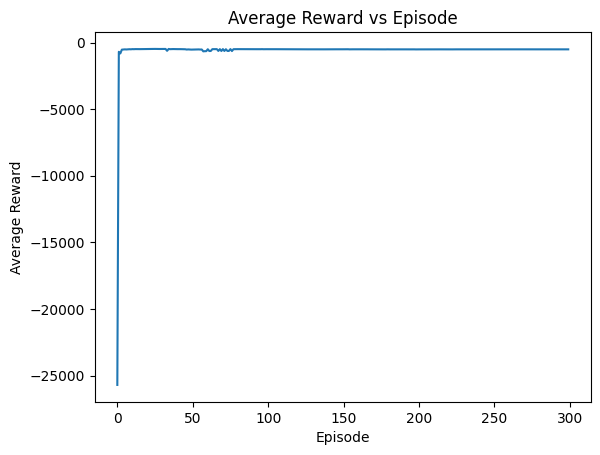

In [5]:

# Training loop

for EP in range(EPISODES):
    # Initial state at theta = 0
    state = np.array([1.0, 0.0, 0.0])  # [cos(theta), sin(theta), theta_dot]
    score, done = 0.0, False
    
    # Pendulum parameters
    mass = 1.5
    length = 0.8
    b = 0.2

    # check = 0

    while not done:
        action, log_prob = agent.choose_action(torch.FloatTensor(state))
        action = action.detach().cpu().numpy()  # GPU tensor to numpy array

        # check+= 1

        # Simulate the pendulum dynamics
        next_state = simulate_pendulum(state, action, mass, length,b)

        # Calculate reward based on angle deviation and angular velocity
        angle_deviation = np.arccos(next_state[0]) - np.pi  # [-pi, pi]
        reward = -angle_deviation ** 2 - 0.1 * next_state[2] ** 2  # Reward function

        # terminate if we get the angle at pi and angular velocity = 0

        if np.abs(angle_deviation) < 0.1 and np.abs(next_state[2]) < 0.1:
            done = True
            reward += 100

        agent.memory.put((state, action, reward, next_state, done))

        score += reward
        state = next_state

        if agent.memory.size() > 1000:  # Start training when 1000 samples collected
            if print_once:
                print("Training started!")
            print_once = False
            agent.train_agent()
        
        # print("loop: ", check)

    print("EP:{}, Avg_Score:{:.1f}".format(EP, score))
    score_list.append(score)

# save scores in a text file pendulum_scores.txt
    
# with open('pendulum_scores.txt', 'w') as f:
#     for score in score_list:
#         f.write(str(score) + '\n')

# save the model
        

# torch.save(agent.PI.state_dict(), 'pendulum_policy.pth')
# torch.save(agent.Q1.state_dict(), 'pendulum_q1.pth')
# torch.save(agent.Q2.state_dict(), 'pendulum_q2.pth')

# Draw reward vs episode plot
import matplotlib.pyplot as plt
plt.plot(score_list)
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.title('Average Reward vs Episode')
plt.show()

Test score:  -513.4931293154766


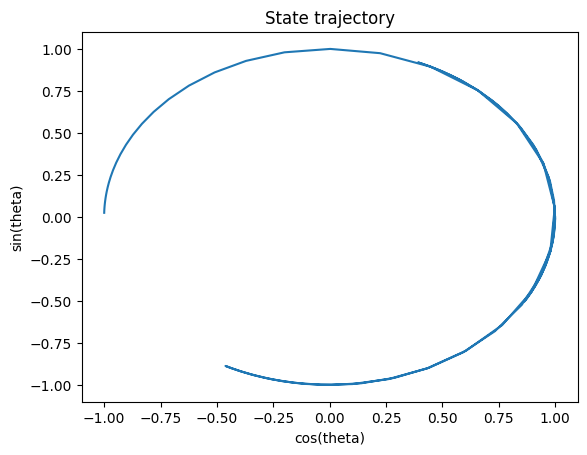

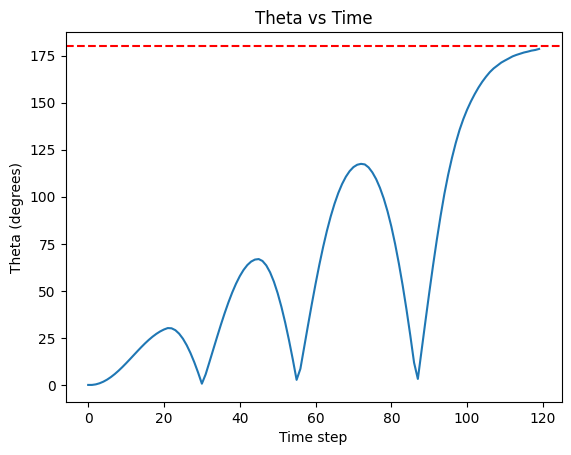

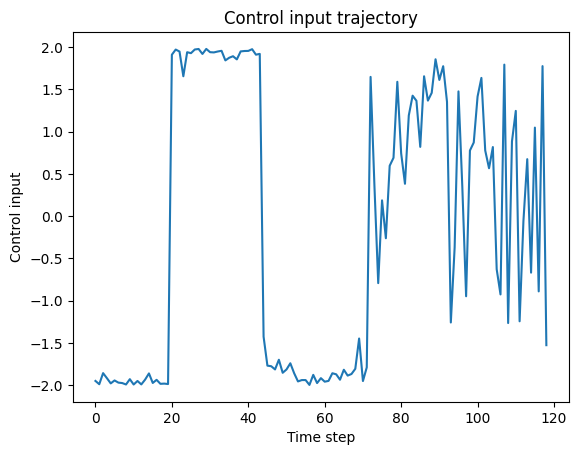

In [6]:
# Test the trained agent
# Draw optimal control input trajectory and corresponding state trajectory

state = np.array([1.0, 0.0, 0.0])  # [cos(theta), sin(theta), theta_dot]
state_list = [state]
action_list = []
score = 0.0
done = False

while not done:
    action, _ = agent.choose_action(torch.FloatTensor(state))
    action = action.detach().cpu().numpy()  # GPU tensor to numpy array
    action_list.append(action)

    next_state = simulate_pendulum(state, action, mass, length,b)

    angle_deviation = np.arccos(next_state[0]) - np.pi  # [-pi, pi]
    reward = -angle_deviation ** 2 - 0.1 * next_state[2] ** 2  # Reward function

    if np.abs(angle_deviation) < 0.1 and np.abs(next_state[2]) < 0.1:
        done = True
        reward += 100

    score += reward
    state = next_state
    state_list.append(state)

print("Test score: ", score)

# Draw the state trajectory

state_list = np.array(state_list)
plt.figure()
plt.plot(state_list[:, 0], state_list[:, 1])
plt.xlabel('cos(theta)')
plt.ylabel('sin(theta)')
plt.title('State trajectory')
plt.show()

# Draw graph of theta in degrees vs time
# Mark the angle at 180 degrees with a dotted line

theta_list = np.arccos(state_list[:, 0]) * 180 / np.pi
plt.figure()
plt.plot(theta_list)
plt.axhline(y=180, color='r', linestyle='--')
plt.xlabel('Time step')
plt.ylabel('Theta (degrees)')
plt.title('Theta vs Time')
plt.show()



# Draw the control input trajectory

action_list = np.array(action_list)
plt.figure()
plt.plot(action_list)
plt.xlabel('Time step')
plt.ylabel('Control input')
plt.title('Control input trajectory')
plt.show()






MovieWriter imagemagick unavailable; using Pillow instead.
/tmp/ipykernel_105675/1039499268.py:39: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  bob.set_data(bob_x, bob_y)  # Set position of the bob


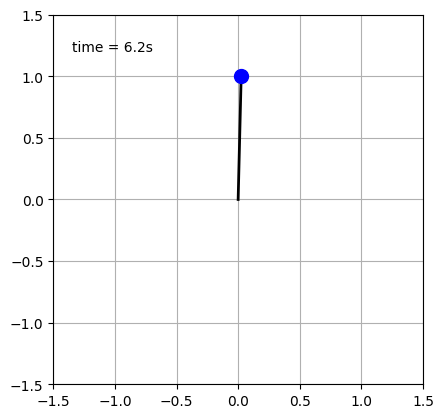

In [7]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

fig, ax = plt.subplots()
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.set_aspect('equal')
ax.grid()

bar, = ax.plot([], [], 'k-', lw=2)  # Bar representing the pendulum rod
bob, = ax.plot([], [], 'bo', ms=10)  # Bob representing the pendulum mass
time_template = 'time = %.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)

def init():
    bar.set_data([], [])
    bob.set_data([], [])
    time_text.set_text('')
    return bar, bob, time_text

def animate(i):
    if i < len(state_list):
        cos_theta, sin_theta, _ = state_list[i]
    else:
        cos_theta, sin_theta, _ = state_list[-1]  # Use the last state after the animation ends

    pendulum_length = 1.0  # Length of the pendulum rod
    
    # Swapping and negating x and y coordinates
    x = [pendulum_length * sin_theta, 0]
    y = [-pendulum_length * cos_theta, 0]
    
    bar.set_data(x, y)  # Set position of the bar

    # Swapping and negating x-coordinate
    bob_x = pendulum_length * sin_theta
    bob_y = -pendulum_length * cos_theta
    bob.set_data(bob_x, bob_y)  # Set position of the bob

    time_text.set_text(time_template % (i * 0.05))
    return bar, bob, time_text

# Extend the state list with the last state repeated for 100 frames
state_list_extended = np.repeat([state_list[-1]], 100, axis=0)

ani = animation.FuncAnimation(fig, animate, frames=len(state_list) + 5, interval=50, blit=True, init_func=init, repeat=False)

# Define a function to hold the last frame for 2 seconds before restarting the animation
def hold_last_frame(frame):
    if frame == len(state_list) + 99:
        plt.pause(1)  # Hold the last frame for 2 seconds

ani.event_source.add_callback(hold_last_frame)

# Save the animation as a gif file
ani.save('pendulum.gif', writer='imagemagick', fps=20, savefig_kwargs={'pad_inches': 0, 'bbox_inches': 'tight'})

plt.show()
